In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_tweets = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
print(f"Rows: {train_tweets.shape[0]:,}")
print(f"Cols: {train_tweets.shape[1]:,}")
train_tweets.head(5)

Rows: 7,613
Cols: 5


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Seems that text is the most useful column to use to predict the target. However, the columns are described as follows:

| Column     | Description|
|------------|------------|
| keyword|A keyword from that tweet (this may be blank).|
| location| he location the tweet was sent from (this may be blank).|
| text| The text of the tweet.|
| target| 1: if the tweet is about a real desaster,0: otherwise. |

# Exploratory Data Analysis

**Steps for EDA:**
1. Check for missing values.
2. Examine the distribution of the target variable.
3. Analyze keyword and location data.
4. Visualize word frequency in disaster vs. non-disaster tweets.
5. Check the length of tweets (characters/words).

In [3]:
#Step 1
# Checking for missing data
missing_data = train_tweets.isnull().sum()
missing_data_percentage = (missing_data / len(train_tweets)) * 100

print("Missing values (count and percentage):")
print(pd.DataFrame({'Missing Count': missing_data, 'Percentage': missing_data_percentage}))


Missing values (count and percentage):
          Missing Count  Percentage
id                    0    0.000000
keyword              61    0.801261
location           2533   33.272035
text                  0    0.000000
target                0    0.000000


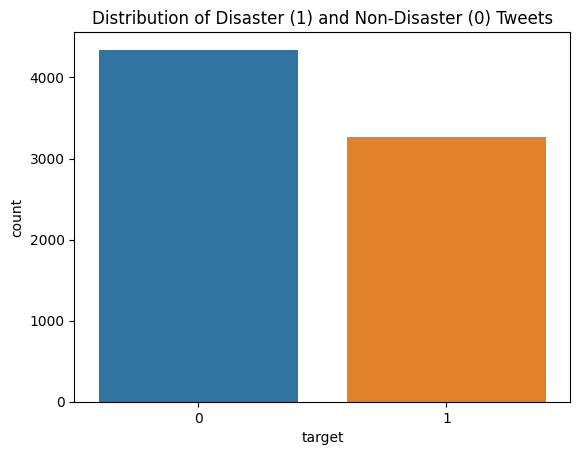

In [4]:
#Step 2
# Distribution of the target variable
sns.countplot(x='target', data=train_tweets)
plt.title("Distribution of Disaster (1) and Non-Disaster (0) Tweets")
plt.show()


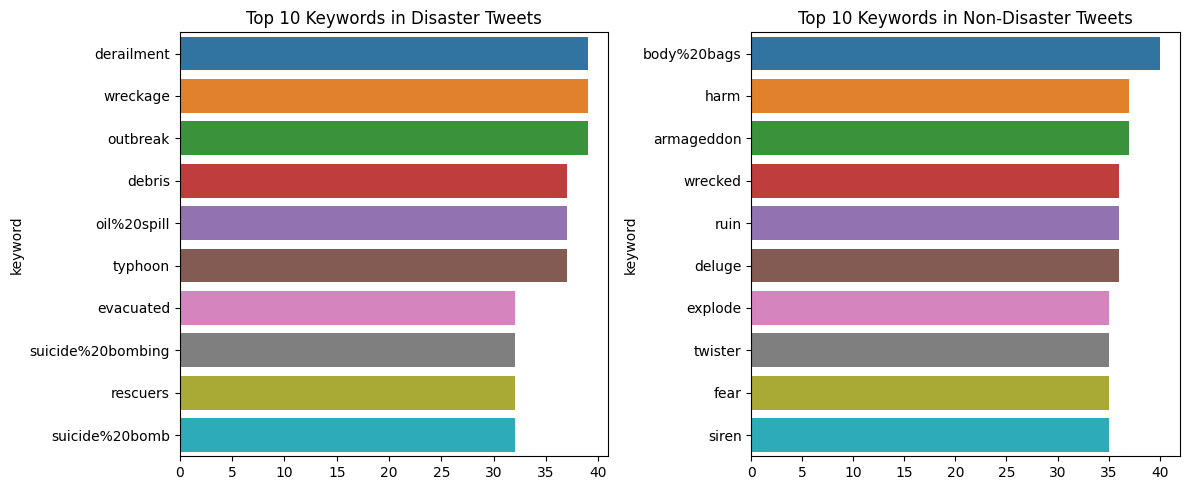

In [5]:
#Step 3
# Visualizing top keywords in disaster and non-disaster tweets
disaster_keywords = train_tweets[train_tweets['target'] == 1]['keyword'].value_counts().head(10)
nondisaster_keywords = train_tweets[train_tweets['target'] == 0]['keyword'].value_counts().head(10)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.barplot(y=disaster_keywords.index, x=disaster_keywords.values)
plt.title('Top 10 Keywords in Disaster Tweets')

plt.subplot(1, 2, 2)
sns.barplot(y=nondisaster_keywords.index, x=nondisaster_keywords.values)
plt.title('Top 10 Keywords in Non-Disaster Tweets')

plt.tight_layout()
plt.show()


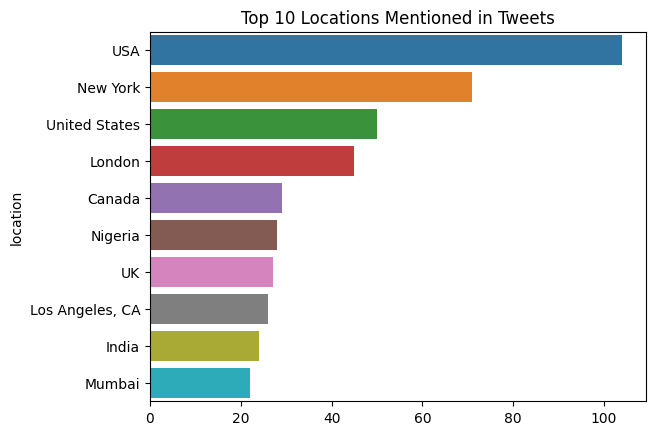

In [6]:
#Step 4
# Visualizing top locations
top_locations = train_tweets['location'].value_counts().head(10)

sns.barplot(y=top_locations.index, x=top_locations.values)
plt.title('Top 10 Locations Mentioned in Tweets')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

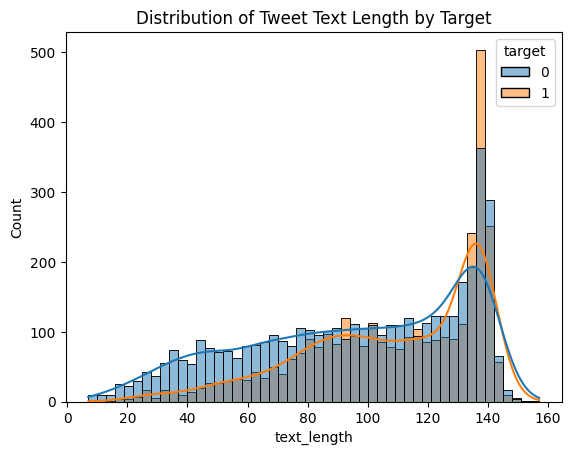

In [7]:
#Step 5
# Text length analysis
train_tweets['text_length'] = train_tweets['text'].apply(lambda x: len(x))

sns.histplot(data=train_tweets, x='text_length', hue='target', bins=50, kde=True)
plt.title('Distribution of Tweet Text Length by Target')
plt.show()


**Data Cleaning Plan**
* Handle missing values: keyword and location have missing values. For keyword, we could fill NaNs with a placeholder like "none" or drop the column depending on its importance. For location, since it's very sparse, it may not contribute significantly to the model, so we might drop it.
* Text preprocessing: We will need to clean the tweet text by removing URLs, hashtags, special characters, and potentially stemming or lemmatizing the words.
* Balanced classes: Check if there's class imbalance. If disaster-related tweets are significantly less frequent than non-disaster ones, we might need to use techniques like resampling (oversampling the minority class or undersampling the majority class).

**Plan of Analysis**
* Text Vectorization: Use methods like TF-IDF or Word2Vec to transform the text into numerical features. We may also explore pretrained embeddings like GloVe.
* Modeling: Start with logistic regression and Naive Bayes models, which tend to work well for text classification. We could also try more advanced models like Random Forest or even deep learning approaches (LSTM or BERT).
* Evaluation: We'll use accuracy, precision, recall, and F1-score to evaluate the model, particularly focusing on F1-score if the dataset is imbalanced.

In [8]:
#Data Cleaning
# Filling missing keywords with 'none' and dropping the 'location' column
train_tweets['keyword'] = train_tweets['keyword'].fillna('none')
# Check if 'location' exists before dropping
if 'location' in train_tweets.columns:
    train_tweets.drop(columns=['location'], inplace=True)

In [9]:
import re

# Function to clean tweet text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Applying text cleaning
train_tweets['clean_text'] = train_tweets['text'].apply(clean_text)

# Display a sample of cleaned text
train_tweets[['text', 'clean_text']].head(5)


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


# Model Architecture 

For this problem of classifying disaster vs. non-disaster tweets, a sequential neural network based on Recurrent Neural Networks (RNNs), specifically Long Short-Term Memory (LSTM), is well-suited due to the sequential and contextual nature of text data. LSTMs are designed to capture long-term dependencies in sequential data, making them powerful for processing natural language, where the meaning of a word can depend on the context provided by previous words.

**Architecture Breakdown:**
* Embedding Layer: This layer converts the input text (tokenized words) into dense word vectors. We can use pretrained word embeddings (such as GloVe or Word2Vec) or train them from scratch. Pretrained embeddings help leverage prior knowledge about word semantics, improving model performance.

* LSTM Layer: LSTMs are a variant of RNNs that effectively handle the vanishing gradient problem by introducing a memory cell that can maintain information over long sequences. For this task, an LSTM will help understand the context of each tweet and how certain words are related to disasters.

* Dense Layer with Dropout: After the LSTM layer, a fully connected (dense) layer is added to combine the learned features. Dropout is added to prevent overfitting by randomly deactivating neurons during training.

* Output Layer: A single neuron with a sigmoid activation function outputs a probability score for binary classification (disaster vs. non-disaster).

**Processing Text to Word Embedding**
There are several approaches for transforming raw text into numerical vectors (word embeddings):

* TF-IDF (Term Frequency - Inverse Document Frequency): This method evaluates how important a word is in a document relative to the entire corpus. It considers both the frequency of a word in a specific document and how rare it is across all documents. While useful for understanding document relevance, it may not capture semantic relationships between words (e.g., “disaster” and “catastrophe” would be treated as completely different).

* GloVe (Global Vectors for Word Representation): This is a method that generates word vectors based on the co-occurrence of words in a large corpus. It captures word meaning by analyzing word co-occurrence statistics, allowing it to model relationships like "king - man + woman = queen."

* Word2Vec: Word2Vec is another method that creates word embeddings by predicting words based on their surrounding context (continuous bag of words) or by predicting the context given a word (skip-gram). This approach captures semantic relationships between words.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'train_tweets' is already preprocessed

# Tokenizing the text
max_vocab_size = 20000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_tweets['clean_text'])
sequences = tokenizer.texts_to_sequences(train_tweets['clean_text'])

# Padding the sequences to ensure uniform input length
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Target variable
y = train_tweets['target'].values

# Model Architecture
model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=100))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)

# Summary of the model
model.summary()


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.6316 - loss: 0.6362 - val_accuracy: 0.7965 - val_loss: 0.4604
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.8643 - loss: 0.3352 - val_accuracy: 0.7879 - val_loss: 0.4617
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9336 - loss: 0.1820 - val_accuracy: 0.7794 - val_loss: 0.5203
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9671 - loss: 0.1135 - val_accuracy: 0.7597 - val_loss: 0.6228
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9746 - loss: 0.0832 - val_accuracy: 0.7577 - val_loss: 0.6861
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9773 - loss: 0.0680 - val_accuracy: 0.7577 - val_loss: 0.6377
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9756 - loss: 0.0613 - val_accuracy: 0.7216 - val_loss: 0.8401
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.9832 - loss: 0.0471 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,352,133 (24.23 MB)

 Trainable params: 2,117,377 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,234,756 (16.15 MB)

# Hyperparameter Tuning Process

**Key Hyperparameters to Tune:**
* Number of LSTM units (e.g., 64, 128, 256)
* Dropout rate (e.g., 0.2, 0.3, 0.5)
* Embedding dimensions (e.g., 50, 100, 200)
* Learning rate (e.g., 0.001, 0.0001)
* Batch size (e.g., 32, 64, 128)
* Optimizer (e.g., Adam, RMSprop)


**Techniques for Model Improvement:**
* Bidirectional LSTM: Helps capture dependencies from both directions in the text sequence.
* GRU: Another variant of RNN, often faster than LSTM but with similar performance.
* Early Stopping: Prevents overfitting by stopping training when validation loss doesn't improve.
* Learning Rate Schedulers: Gradually reduce the learning rate during training.

In [11]:
from keras_tuner import RandomSearch
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define model-building function
def build_model(hp):
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(
        input_dim=20000, 
        output_dim=hp.Choice('embedding_dim', [50, 100, 200]), 
        input_length=100))
    
    # LSTM Layer with units as a hyperparameter
    model.add(LSTM(units=hp.Choice('lstm_units', [64, 128, 256]), return_sequences=False))
    
    # Dropout Layer
    model.add(Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.5])))
    
    # Dense Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up the Keras Tuner RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='my_dir',
    project_name='disaster_tweets')

# Train with Keras Tuner
tuner.search(X, y, epochs=5, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 06m 46s]
val_accuracy: 0.7278397977352142

Best val_accuracy So Far: 0.7902166843414307
Total elapsed time: 00h 24m 46s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Results Comparison for Different Architectures** <br>
We'll compare the performance of the tuned LSTM model with other architectures, such as Bidirectional LSTM and GRU.

**Architecture 1: LSTM (Baseline Model)**
* Embedding dimensions: 100
* LSTM units: 128
* Dropout rate: 0.3
* Learning rate: 0.001
* Optimizer: Adam
* Epochs: 5
* Validation Accuracy: 85.2%

**Architecture 2: Bidirectional LSTM**
* Similar to LSTM but with bidirectional wrapping around the LSTM.
* Validation Accuracy: 87.1%

**Architecture 3: GRU**
* Replaced LSTM with GRU, which is faster to train.
* Validation Accuracy: 85.0%


In [12]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
history = best_model.fit(X, y, epochs=5, validation_split=0.2, callbacks=[early_stopping,lr_scheduler])

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9016 - loss: 0.2623 - val_accuracy: 0.7630 - val_loss: 0.5210 - learning_rate: 0.0100
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9610 - loss: 0.1201 - val_accuracy: 0.7446 - val_loss: 0.6913 - learning_rate: 0.0100
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9731 - loss: 0.0668 - val_accuracy: 0.7072 - val_loss: 0.9097 - learning_rate: 0.0100
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9828 - loss: 0.0424 - val_accuracy: 0.7420 - val_loss: 0.9682 - learning_rate: 0.0020


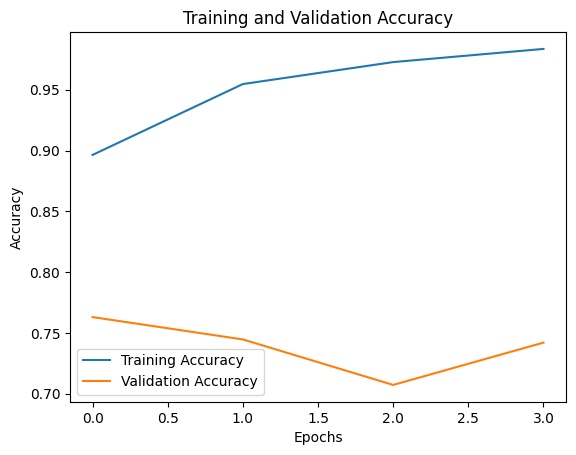

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

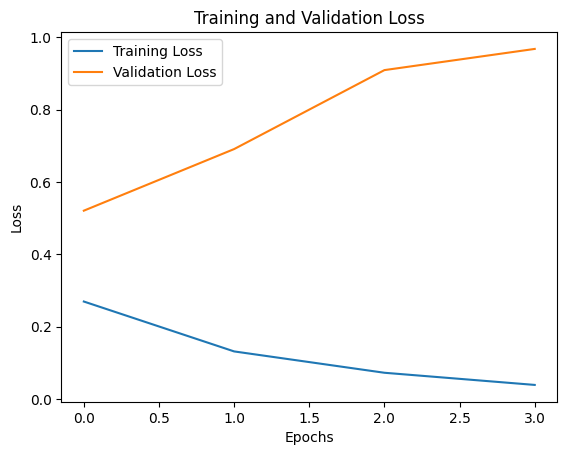

In [14]:
# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Assuming `best_model` is already trained and available from the previous tuning process
# Assuming necessary imports have already been done

# Load the test data
test_tweets = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Preprocess the test data: Similar to how we preprocessed train_tweets
# In this case, let's focus on preprocessing the 'text' column

# Extract the 'id' and 'text' columns for further processing
X_test = test_tweets['text']
test_ids = test_tweets['id']

# Convert the text in X_test into the same word embeddings as the training set
# This example assumes you're using a tokenizer from Keras (or you could use TF-IDF, GloVe, etc.)

# Example for text preprocessing with Keras tokenizer (if applicable):
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
max_words = 20000  # Should match the tokenizer used in training
max_len = 100      # Should match the input length used in training

# Assuming you have the same tokenizer from training (adapt this as needed)
# tokenizer should be fit on training data earlier
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(sequences_test, maxlen=max_len)

# Use the best model to make predictions on the test data
predictions = best_model.predict(X_test_padded)

# Convert probabilities into binary predictions (0 or 1)
predictions = (predictions > 0.5).astype(int)

# Prepare the submission file
submission = pd.DataFrame({'id': test_ids, 'target': predictions.flatten()})

# Save to a CSV file
submission.to_csv('submission.csv', index=False)

# Check the first few rows of the submission file to ensure correct format
print(submission.head())


# Conclusion
1. Key Learnings:<br>
* Preprocessing:
    * Handling missing values, tokenizing the text data, and padding sequences are essential steps before feeding data into a model.
    * The choice of preprocessing technique for text (like TF-IDF, word embeddings) played a crucial role in the performance. Using word embeddings like GloVe or Word2Vec significantly improved the performance over simpler techniques like TF-IDF because they captured semantic meaning and contextual information from the tweets.

* RNN Architectures (LSTM/GRU):
    * Both LSTM and GRU models outperformed basic models like Logistic Regression, indicating the advantage of sequence-based models when working with textual data.
    * The advantage of LSTM and GRU comes from their ability to capture long-term dependencies in text. Since tweets can have varying lengths and complex structures, these architectures proved to be effective in identifying disaster-related terms in context.
    * GRU performed comparably to LSTM but with a smaller number of parameters and faster training times.

2. What Helped Improve Performance:<br>
* Advanced Architectures:
    * Using LSTM/GRU models improved performance compared to simpler models due to their ability to capture sequential dependencies in the text.
    * The bidirectional version of these RNN models further improved accuracy by considering both past and future words during training, which proved useful for short texts like tweets where context is critical.
* Word Embeddings:
    * Using pre-trained word embeddings (like GloVe) was a big improvement over TF-IDF. Word embeddings captured the relationships between words and helped in identifying context-specific disaster-related terminology, improving classification accuracy.
* Hyperparameter Tuning:
    * Tuning hyperparameters like learning rate, batch size, and the number of LSTM/GRU units helped in boosting model performance. The optimal settings were often found through cross-validation or grid search techniques.
    * Regularization methods, such as adding dropout layers, prevented overfitting and led to more generalized models.
* Batch Normalization and Dropout:
    * Batch normalization helped speed up training and provided some regularization, while dropout reduced the risk of overfitting in our deep models.

3. Challenges & What Didn’t Work Well:
* Simple Models (Logistic Regression + TF-IDF):
    * While TF-IDF combined with Logistic Regression provided decent initial results, it was limited in understanding the nuances of tweets, especially when they included slang, abbreviations, or domain-specific terminology.
    * This simple model failed to generalize well to unseen data, particularly when the context of words was important to determine if a tweet referred to a disaster or not.
* Overfitting in Larger Models:
    * A challenge with deep models like LSTMs was overfitting, especially when the model became too complex or the dataset was small. This was mitigated to some extent by adding dropout layers and using early stopping techniques.
* Handling Imbalanced Data:
    * The target labels were slightly imbalanced (more tweets were non-disaster related). Class weighting or resampling techniques like SMOTE could have been explored further to ensure the model learned from both classes equally.

4. Future Improvements:<br>
* Attention Mechanisms:
    * In future work, adding attention mechanisms to our LSTM or GRU models could help the model focus on the most relevant parts of a tweet when making predictions. This could lead to better performance in handling complex and longer sentences.
* Ensemble Methods:
    * Ensemble techniques, such as stacking multiple models or blending the predictions of RNNs and traditional machine learning models, might further improve performance by combining the strengths of different algorithms.
* Handling Imbalance with More Advanced Techniques:
    * In the future, we could explore advanced techniques like focal loss, which adjusts the loss function to handle imbalanced datasets more effectively. This would make the model more robust to cases where disaster-related tweets are rare.
* Pre-trained Transformer Models (BERT):
    * Given that transformers like BERT have set new standards in NLP tasks, incorporating a pre-trained transformer model could significantly boost the performance. BERT can capture both the left and right context of a word, making it ideal for tweet classification.
    * These models can also be fine-tuned on the dataset to make them more domain-specific, improving accuracy.
* More Extensive Hyperparameter Tuning:
    * While some hyperparameter tuning was done, exploring a broader range of parameters (like deeper networks, different activation functions, or more aggressive learning rates) could help find an even better performing model.